In [338]:
from backend.daps.data import Devices, Speakers
from backend.daps.loader import DAPSLoader
from backend.audio_to_spectrogram_converter import AudioToSpectrogramConverter
from backend.tsrc.loader import TSRCLoader
from backend.tsrc.data import Environments
from backend import audio_data

import PIL
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import librosa

from ipywidgets import widgets
from ipywidgets import interactive
from IPython.display import Audio
from tqdm import tqdm

import cv2
import os

In [339]:
path_to_spectrograms_raw = "../data/v2/tsrc_sprectrograms_without_clean"
path_to_spectrograms_denoised = "../data/v2/tsrc_sprectrograms"
path_to_spectrograms_audio = "../data/v2/tsrc_train_test/"

%load_ext autoreload
%autoreload 2

sns.set_theme(rc={'figure.figsize':(20,6)})

sns.set_theme(context='notebook', style = "white", palette=None)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<div style="text-align:center;
            font-size:30px;
            border-bottom:solid;
            background-color:#651A80;
            opacity:0.5;
            color:white;
            border-roundness:30px;
            border-radius: 25px;">
    Reading data
    </div>

In [360]:
class SpectrogramData():
    def __init__(self, file_path : str, speaker_id : str, recording_no : int , train_validaton_test : str, class_id : int):
        self.file_path = file_path
        self.speaker_id = speaker_id
        self.recording_no = recording_no
        self.train_validaton_test = train_validaton_test
        self.class_id = class_id

class SpectrogramLoader():
        
    @staticmethod
    def load_data(path):
        objects_list = []
        
        for subdir, dirs, files in os.walk(path):
            if dirs is not None:
                for file in files:
                    file_path = os.path.join(subdir, file)
                    file_path = os.path.normpath(file_path)
                    class_id = file_path.split('\\')[-2]
                    train_validaton_test = file_path.split('\\')[-3]
                    speaker_id = file[:8]
                    recording_no = file.removesuffix(".png").split("_")[1]

                    data_object = SpectrogramData(file_path=file_path,
                                                  speaker_id=speaker_id,
                                                  recording_no=int(recording_no),
                                                  train_validaton_test=train_validaton_test,
                                                  class_id=int(class_id))
                    objects_list.append(data_object)
        
        return objects_list
    
class AudioLoader():
        
    @staticmethod
    def __load_audio(file_path: str, train_validaton_test : str, speaker_id : str, class_id : str) -> audio_data.AudioData:
        y, sr = librosa.load(file_path)
        return audio_data.AudioData(y, sr, train_validaton_test, speaker_id, class_id)
    
    @staticmethod
    def load_data(path):
        objects_list = []
        
        for subdir, dirs, files in os.walk(path):
            if dirs is not None:
                for file in tqdm(files):
                    file_path = os.path.join(subdir, file)
                    file_path = os.path.normpath(file_path)
                    train_validaton_test = file_path.split('\\')[-3]
                    speaker_id = file.split('_')[1]
                    class_id = file_path.split('\\')[-2]

                    data_object = AudioLoader.__load_audio(file_path=file_path,
                                                  train_validaton_test=train_validaton_test,
                                                  speaker_id=speaker_id,
                                                  class_id=int(class_id))
                    objects_list.append(data_object)
        
        return objects_list

In [361]:
def color_histogram(file_path, black_threshold):   
    img = cv2.imread(file_path)
    imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    colors = ['r', 'g', 'b']
    histograms = []
    
    mask = np.logical_not(np.all(imgRGB < black_threshold, axis=2)).astype(np.uint8)
    for i, color in enumerate(colors):
        hist = cv2.calcHist([imgRGB], [i], mask, [256], [0,256])
        histograms.append(hist)

    return histograms
    
def plot_color_histogram(file_path, black_threshold):
    img = cv2.imread(file_path)
    imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    #plt.figure()
    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(imgRGB)
    
    colors = ['r', 'g', 'b']
    histograms = []
    
    mask = np.logical_not(np.all(imgRGB < black_threshold, axis=2)).astype(np.uint8)
    for i, color in enumerate(colors):
        hist = cv2.calcHist([imgRGB], [i], mask, [256], [0,256])
        histograms.append(hist)
        axes[1].plot(hist, color,)
        
    plt.xlabel("Pixel intensity")
    plt.ylabel("# of Pixels")
    plt.show()
    
def grey_histogram(file_path, black_threshold):   
    img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    
    mask = (img > black_threshold).astype(np.uint8)
    hist = cv2.calcHist([img], [0], mask, [256], [0,256])

    return hist

def plot_grey_histogram(file_path, black_threshold):
    img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    
    #plt.figure()
    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(img, cmap='gray')
    
    
    mask = (img > black_threshold).astype(np.uint8)
    hist = cv2.calcHist([img], [0], mask, [256], [0,256])
    axes[1].plot(hist)
        
    plt.xlabel("Pixel intensity")
    plt.ylabel("# of Pixels")
    plt.show()

In [341]:
audio_data = AudioLoader().load_data(path_to_spectrograms_audio)

0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████| 172/172 [00:00<00:00, 718.12it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████| 15587/15587 [00:23<00:00, 661.81it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 618.91it/s]


In [342]:
spectrogram_data_raw = SpectrogramLoader().load_data(path_to_spectrograms_raw)
spectrogram_data_denoised = SpectrogramLoader().load_data(path_to_spectrograms_denoised)

class_id_list = []
sample_len_list = []
sample_rate_list = []
speaker_id_list = []
train_validaton_test_list = []

for audio in audio_data:
    class_id_list.append(audio.class_id)
    sample_len_list.append(len(audio.samples))
    sample_rate_list.append(audio.sample_rate)
    speaker_id_list.append(audio.speaker_id)
    train_validaton_test_list.append(audio.train_validaton_test)
    
df = pd.DataFrame({
                   "sample_len": sample_len_list, 
                   "sample_rate": sample_rate_list, 
                   "speaker_id": speaker_id_list,
                   "class_id": class_id_list, 
                   "train_validaton_test" : train_validaton_test_list})
df['audio_length'] = df['sample_len'] / df['sample_rate']

In [358]:
audio_statistic_0 = df[df['class_id'] == 0][['audio_length']].describe().rename(columns = {'audio_length' : 'class_0'})
audio_statistic_1 = df[df['class_id'] == 1][['audio_length']].describe().rename(columns = {'audio_length' : 'class_1'})

In [359]:
pd.concat([audio_statistic_0, audio_statistic_1], axis = 1)

,class_0,class_1
count,16094.000000,15919.000000
mean,0.982136,0.982080
std,0.064436,0.063199
min,0.418005,0.418005
25%,1.000000,1.000000
50%,1.000000,1.000000
75%,1.000000,1.000000
max,1.000000,1.000000


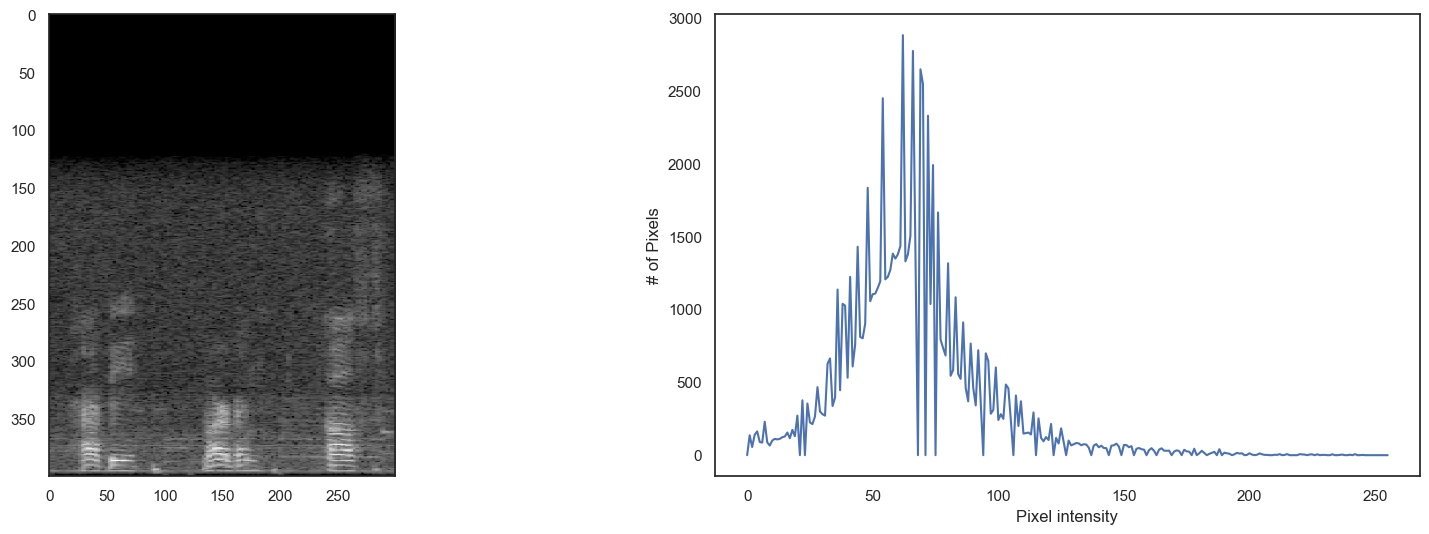

In [363]:
plot_grey_histogram(spectrogram_data_raw[0].file_path, 0)

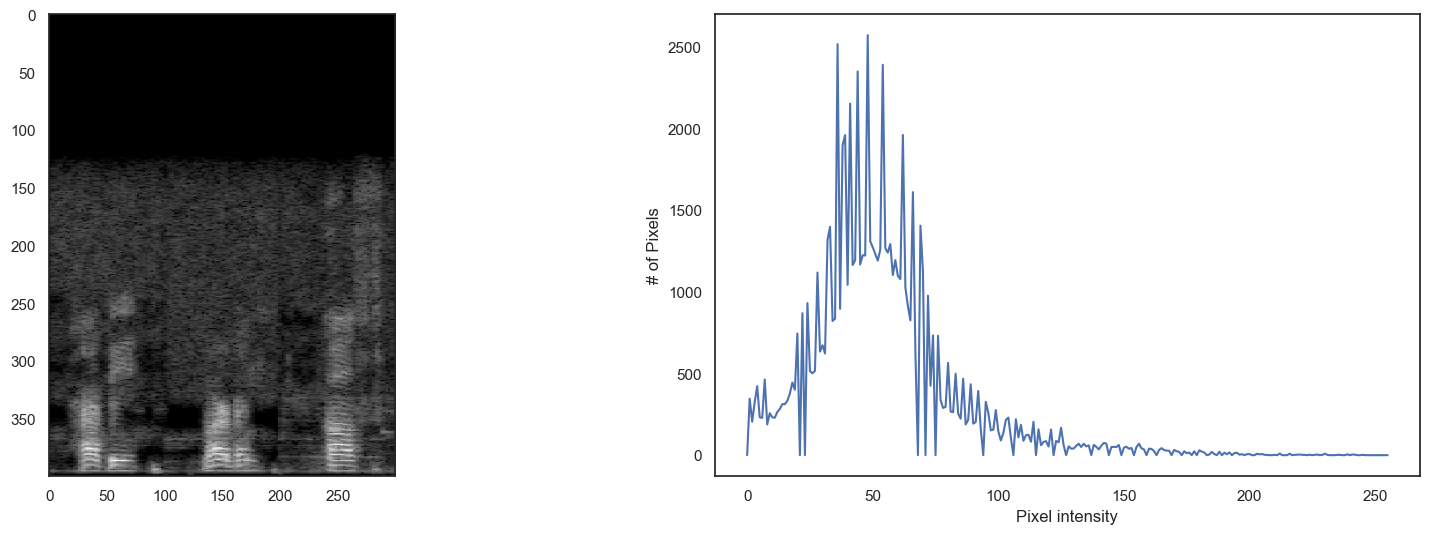

In [364]:
greyHistogram(spectrogram_data_denoised[0].file_path, 0)

<div style="text-align:center;
            font-size:30px;
            border-bottom:solid;
            background-color:#651A80;
            opacity:0.5;
            color:white;
            border-roundness:30px;
            border-radius: 25px;">
    Overall statistics
    </div>

In [145]:
classes_id = [spec.class_id for spec in spectrogram_data_denoised]
df_classes_id = pd.DataFrame({'class_id' : [0, 1], 'count' : [len(classes_id) - np.count_nonzero(classes_id), np.count_nonzero(classes_id)]})

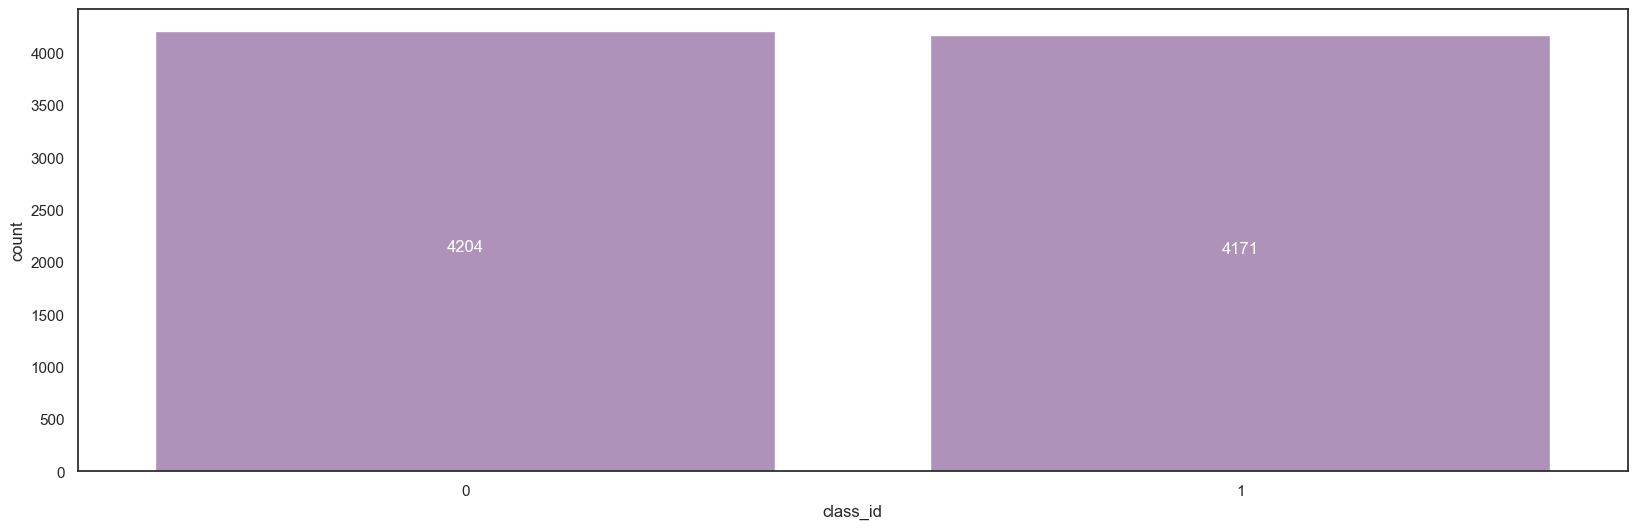

In [143]:
ax = sns.barplot(df_classes_id, x="class_id", y="count", color="#B28CBF")
for i, v in enumerate(df_classes_id['count']):
   ax.text(i, v/2, str(v), ha='center', color='white')

In [292]:
print(f"Audio files: {len(audio_data)}")
print(f"Number of unique speakers in train dataset: {len(df.speaker_id.unique())}")

Audio files: 11634
Number of unique speakers in train dataset: 1818


<div style="text-align:center;
            font-size:30px;
            border-bottom:solid;
            background-color:#651A80;
            opacity:0.5;
            color:white;
            border-roundness:30px;
            border-radius: 25px;">
    Audio statistics
    </div>

In [260]:
print(f"Mean audio length: {df.audio_length.mean()}s")
print(f"Variance of audio length: {df.audio_length.var()}s")

Mean audio length: 0.9831877283604978s
Variance of audio length: 0.003673075971218671s


C:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='audio_length', ylabel='Count'>

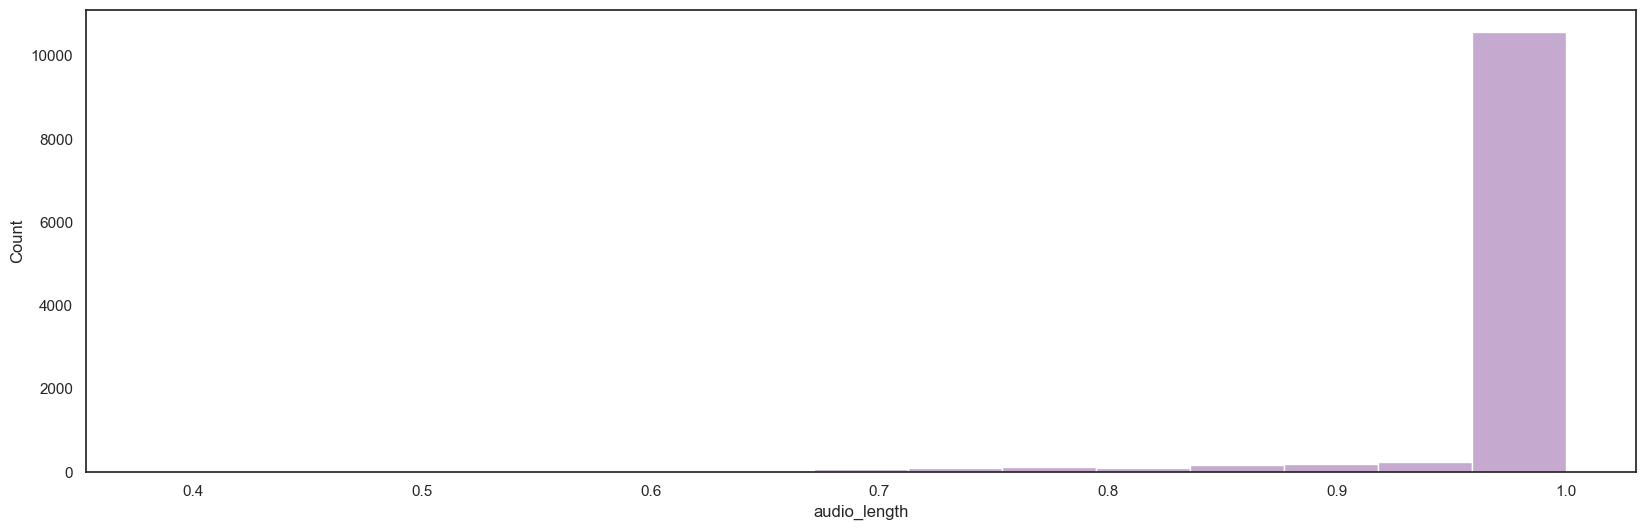

In [239]:
sns.histplot(df, x="audio_length", color="#B28CBF")

<div style="text-align:center;
            font-size:30px;
            border-bottom:solid;
            background-color:#651A80;
            opacity:0.5;
            color:white;
            border-roundness:30px;
            border-radius: 25px;">
    Color histograms for same speaker
    </div>

In [365]:
unique_speakers = np.unique([spec.speaker_id for spec in spectrogram_data_denoised])

i = 3
speaker_1_raw = [spec for spec in spectrogram_data_raw if spec.speaker_id == unique_speakers[i]]
speaker_1_denoise = [spec for spec in spectrogram_data_denoised if spec.speaker_id == unique_speakers[i]]

In [366]:
k = 2

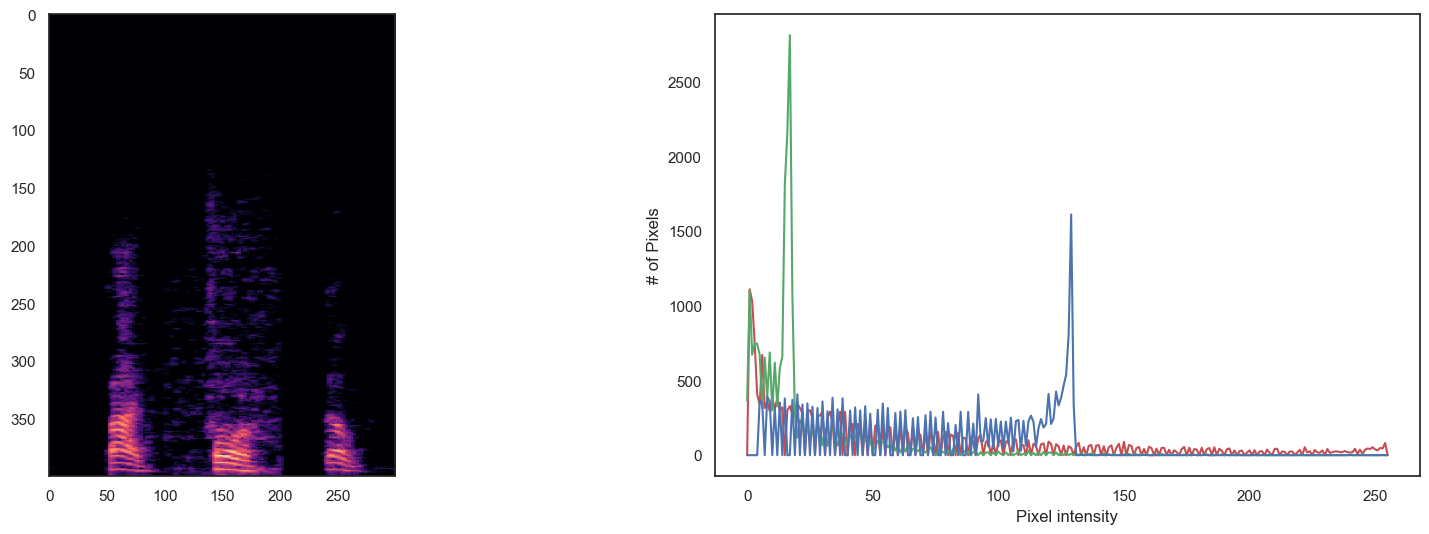

In [367]:
plot_color_histogram(speaker_1_raw[k].file_path, black_threshold=5)

<div style="text-align:center;
            font-size:30px;
            border-bottom:solid;
            background-color:#651A80;
            opacity:0.5;
            color:white;
            border-roundness:30px;
            border-radius: 25px;">
    Prepering mean histograms
    </div>

In [370]:
df[df.class_id == 0].shape[0]

16094

In [377]:
len([sd for sd in spectrogram_data_denoised if sd.class_id == 0])

4213

In [378]:
len([sd for sd in spectrogram_data_raw if sd.class_id == 0])

4942

In [380]:
def mean_color_histogram(spectrogram_data : list, black_threshold):
    class_0_count  = len([sd for sd in spectrogram_data if sd.class_id == 0])
    class_1_count  = len([sd for sd in spectrogram_data if sd.class_id == 1])

    class_0_histograms = {'r' : [], 'g' : [], 'b' : []}
    class_1_histograms = {'r' : [], 'g' : [], 'b' : []}

    for sd in tqdm(spectrogram_data):

        hist = color_histogram(sd.file_path, black_threshold=black_threshold)

        if sd.class_id == 0:
            class_0_histograms['r'].append(hist[0])
            class_0_histograms['g'].append(hist[1])
            class_0_histograms['b'].append(hist[2])
        else:
            class_1_histograms['r'].append(hist[0])
            class_1_histograms['g'].append(hist[1])
            class_1_histograms['b'].append(hist[2])
    
    mean_color_histogram_0 = {}
    mean_color_histogram_1 = {}
    
    for color in ['r', 'g', 'b']:
        if len(class_0_histograms[color]) > 0:
            mean_color_histogram_0[color] = np.mean(np.hstack(class_0_histograms[color]), axis = 1)
        if len(class_1_histograms[color]) > 0:
            mean_color_histogram_1[color] = np.mean(np.hstack(class_1_histograms[color]), axis = 1)
    
    return mean_color_histogram_0, mean_color_histogram_1

In [382]:
mean_color_histogram_0, mean_color_histogram_1 = mean_color_histogram(spectrogram_data_raw, 5)

100%|█████████████████████████████████████████████████████████████████████████████| 9829/9829 [00:52<00:00, 188.01it/s]


In [230]:
class_0_count  = df_classes_id[df_classes_id.class_id == 0]['count'].item()
class_1_count  = df_classes_id[df_classes_id.class_id == 1]['count'].item()

class_0_histograms = {'r' : [], 'g' : [], 'b' : []}
class_1_histograms = {'r' : [], 'g' : [], 'b' : []}

for sd in tqdm(spectrogram_data_raw):
    
    hist = color_histogram(sd.file_path, black_threshold=5)
    
    if sd.class_id == 0:
        #class_0_histograms.append(hist)
        class_0_histograms['r'].append(hist[0])
        class_0_histograms['g'].append(hist[1])
        class_0_histograms['b'].append(hist[2])
    else:
        class_1_histograms['r'].append(hist[0])
        class_1_histograms['g'].append(hist[1])
        class_1_histograms['b'].append(hist[2])

100%|█████████████████████████████████████████████████████████████████████████████| 9799/9799 [00:56<00:00, 173.78it/s]


In [231]:
mean_color_histogram_0 = {}
mean_color_histogram_1 = {}

for color in ['r', 'g', 'b']:
    if len(class_0_histograms[color]) > 0:
        mean_color_histogram_0[color] = np.mean(np.hstack(class_0_histograms[color]), axis = 1)
    if len(class_1_histograms[color]) > 0:
        mean_color_histogram_1[color] = np.mean(np.hstack(class_1_histograms[color]), axis = 1)

<div style="text-align:center;
            font-size:30px;
            border-bottom:solid;
            background-color:#651A80;
            opacity:0.5;
            color:white;
            border-roundness:30px;
            border-radius: 25px;">
    Mean color histogram (all colors) class 0 vs class 1
    </div>

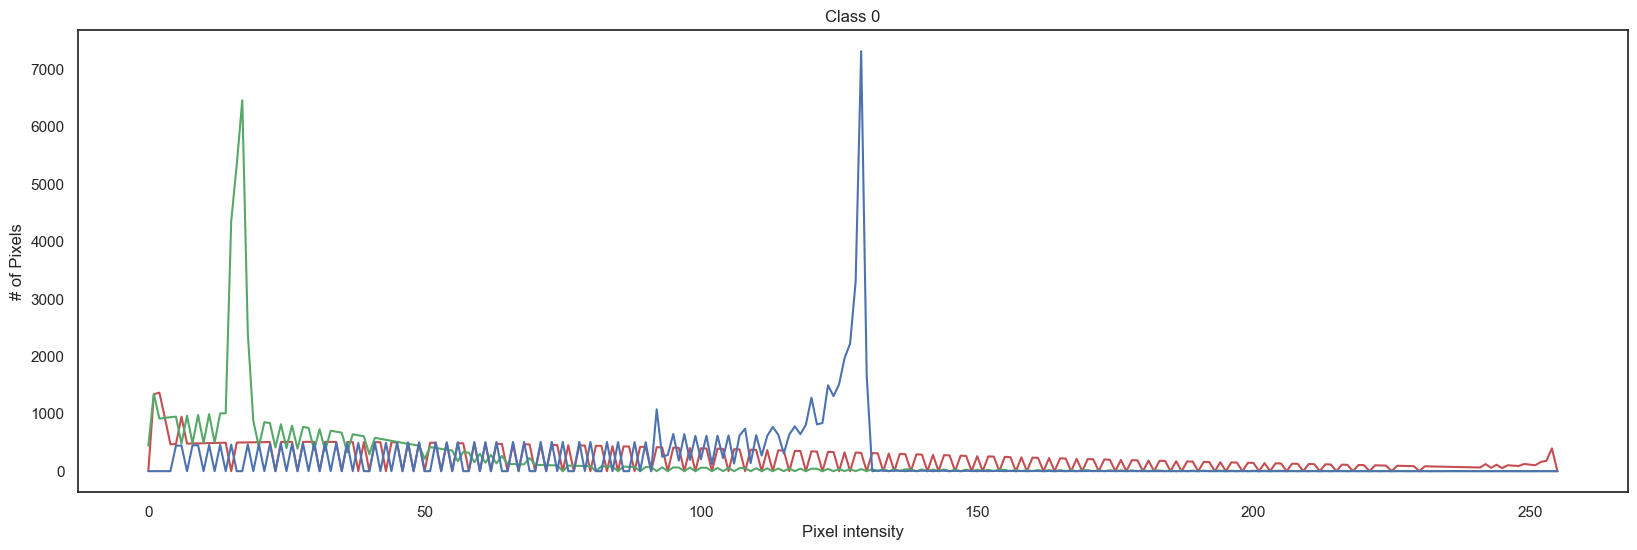

In [383]:
for color in ['r', 'g', 'b']:
    plt.plot(mean_color_histogram_0[color], color=color)

plt.xlabel("Pixel intensity")
plt.ylabel("# of Pixels")
plt.title("Class 0")
plt.show()

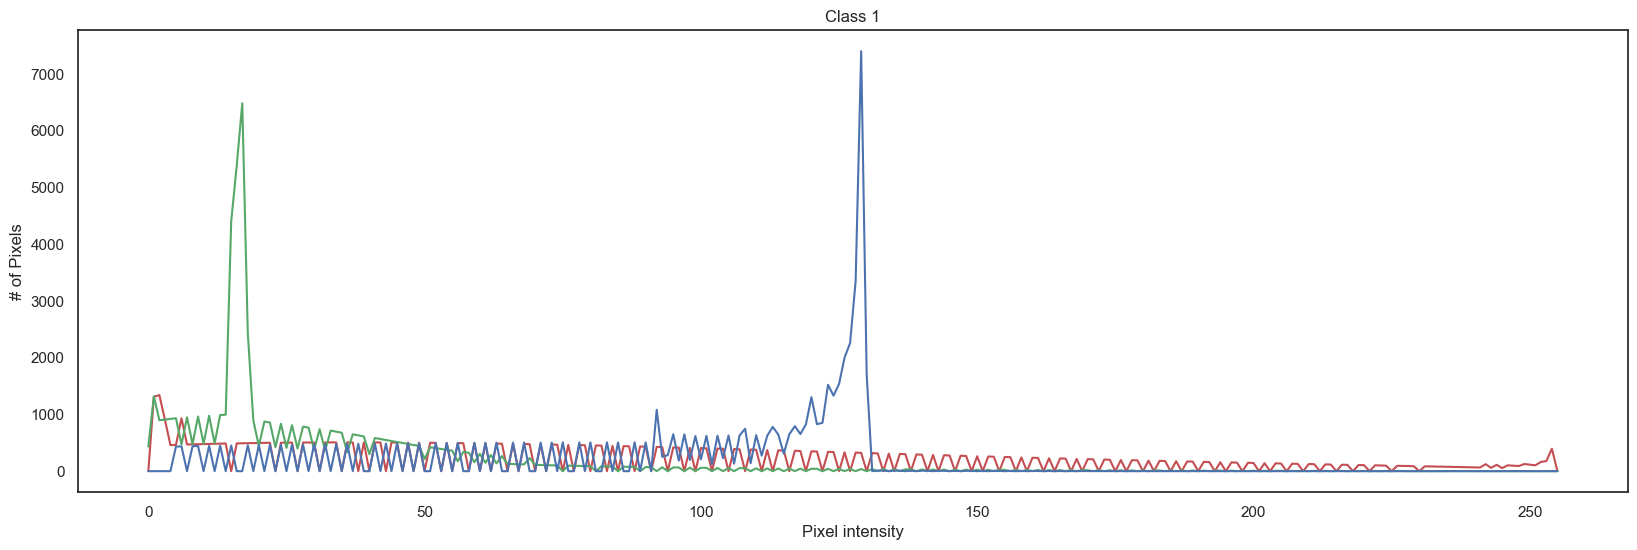

In [287]:
for color in ['r', 'g', 'b']:
    plt.plot(mean_color_histogram_1[color], color=color)

plt.xlabel("Pixel intensity")
plt.ylabel("# of Pixels")
plt.title("Class 1")
plt.show()

<div style="text-align:center;
            font-size:30px;
            border-bottom:solid;
            background-color:#651A80;
            opacity:0.5;
            color:white;
            border-roundness:30px;
            border-radius: 25px;">
    Mean color histogram (red) class 0 vs class 1
    </div>

In [271]:
color = 'r'

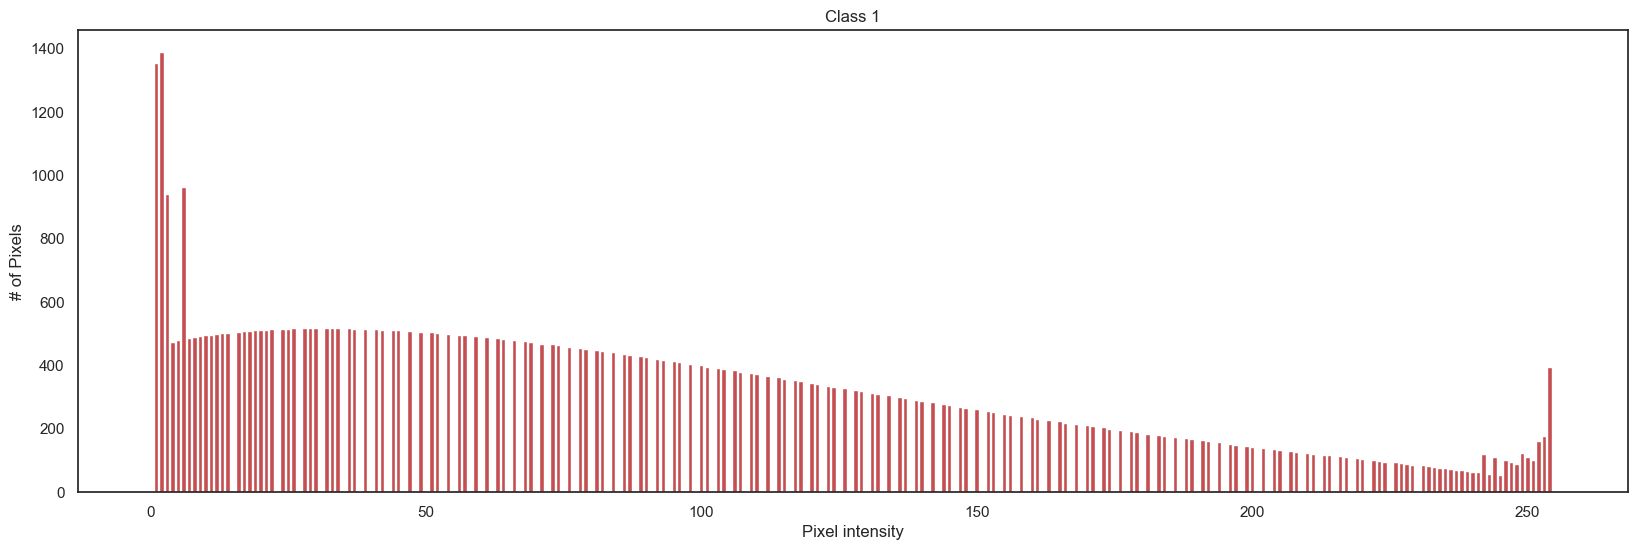

In [281]:
color = 'r'
plt.bar(range(len(mean_color_histogram_0[color])), mean_color_histogram_0[color], color=color)

plt.xlabel("Pixel intensity")
plt.ylabel("# of Pixels")
plt.title("Class 1")
plt.show()

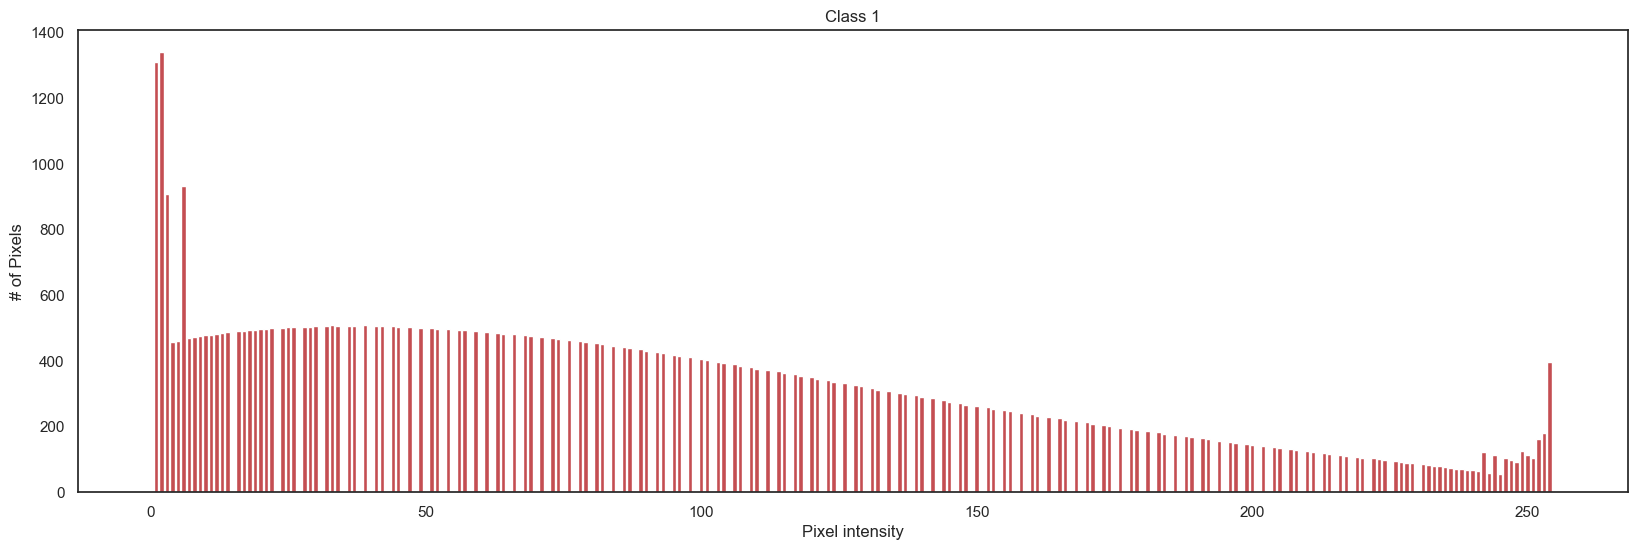

In [273]:
plt.bar(range(len(mean_color_histogram_1[color])), mean_color_histogram_1[color], color=color)

plt.xlabel("Pixel intensity")
plt.ylabel("# of Pixels")
plt.title("Class 1")
plt.show()

In [274]:
metrics.mean_absolute_error(mean_color_histogram_0[color], mean_color_histogram_1[color])

3.720252

<div style="text-align:center;
            font-size:30px;
            border-bottom:solid;
            background-color:#651A80;
            opacity:0.5;
            color:white;
            border-roundness:30px;
            border-radius: 25px;">
    Mean color histogram (green) class 0 vs class 1
    </div>

In [249]:
color = 'g'

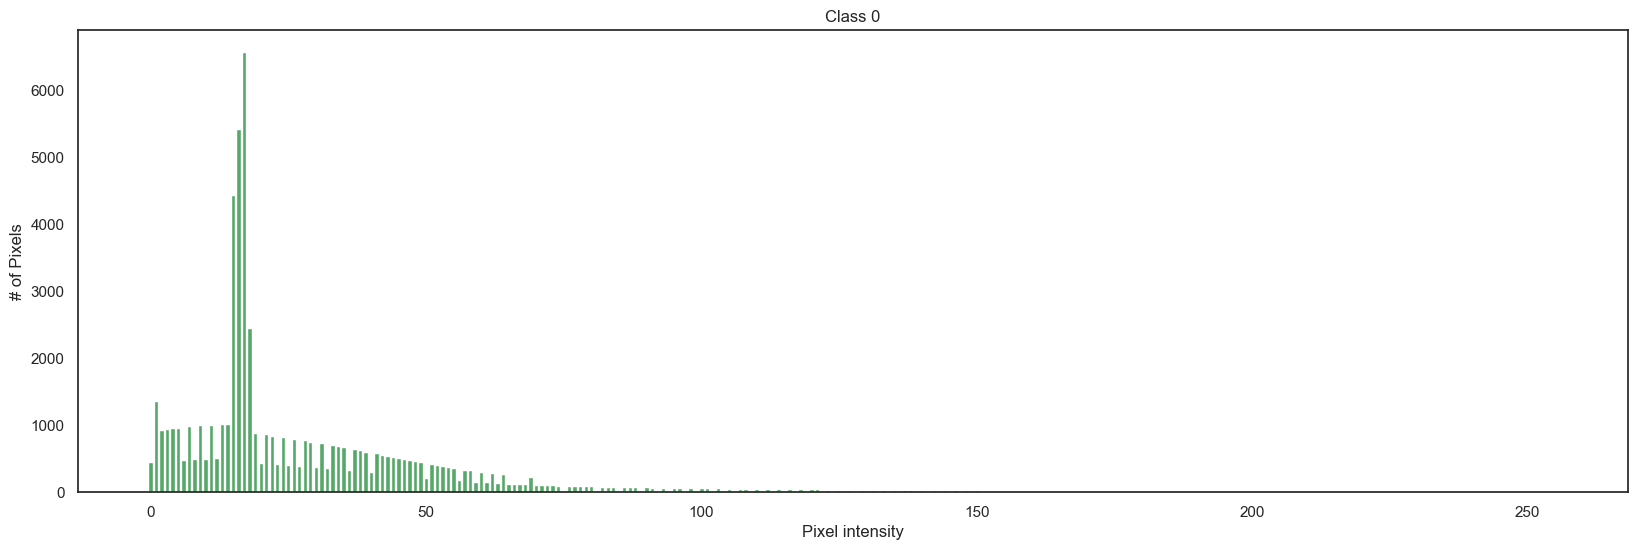

In [250]:
plt.bar(range(len(mean_color_histogram_0[color])), mean_color_histogram_0[color], color=color)

plt.xlabel("Pixel intensity")
plt.ylabel("# of Pixels")
plt.title("Class 0")
plt.show()

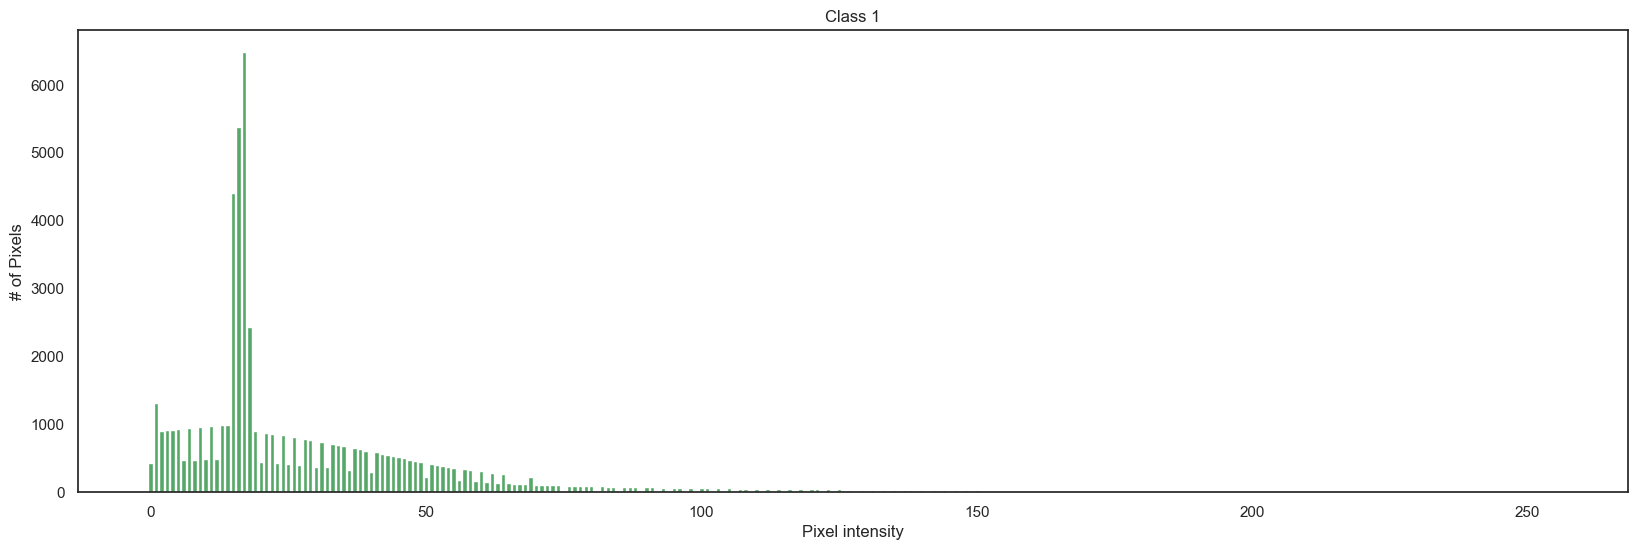

In [251]:
plt.bar(range(len(mean_color_histogram_1[color])), mean_color_histogram_1[color], color=color)

plt.xlabel("Pixel intensity")
plt.ylabel("# of Pixels")
plt.title("Class 1")
plt.show()

<div style="text-align:center;
            font-size:30px;
            border-bottom:solid;
            background-color:#651A80;
            opacity:0.5;
            color:white;
            border-roundness:30px;
            border-radius: 25px;">
    Mean color histogram (blue) class 0 vs class 1
    </div>

In [252]:
color = 'b'

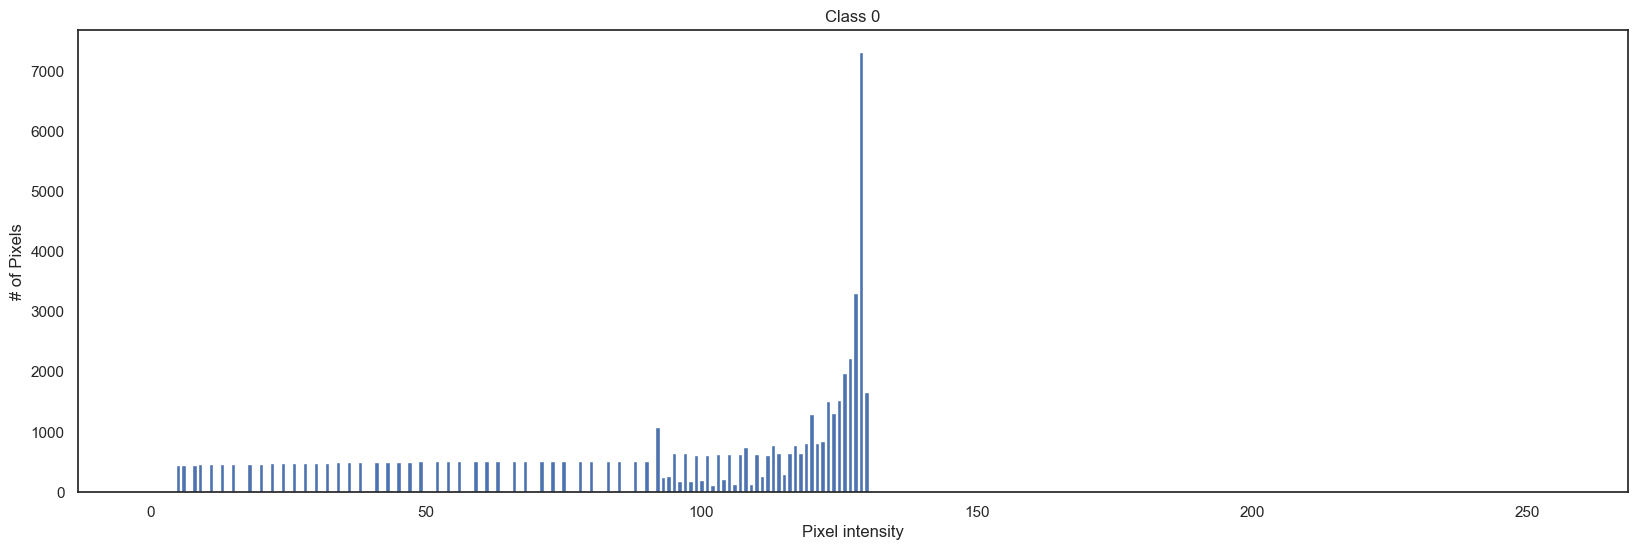

In [253]:
plt.bar(range(len(mean_color_histogram_0[color])), mean_color_histogram_0[color], color=color)

plt.xlabel("Pixel intensity")
plt.ylabel("# of Pixels")
plt.title("Class 0")
plt.show()

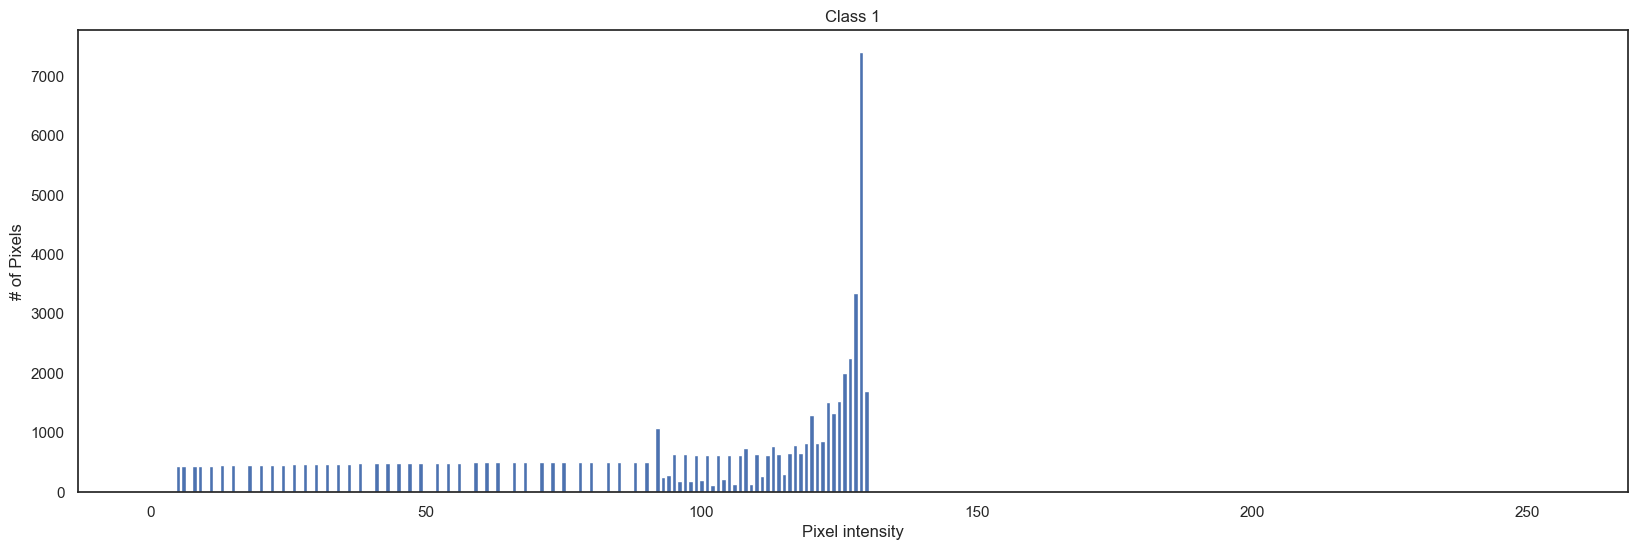

In [254]:
plt.bar(range(len(mean_color_histogram_1[color])), mean_color_histogram_1[color], color=color)

plt.xlabel("Pixel intensity")
plt.ylabel("# of Pixels")
plt.title("Class 1")
plt.show()

In [269]:
from sklearn import metrics

In [270]:
metrics.mean_absolute_error(mean_color_histogram_0['b'], mean_color_histogram_1['b'])

3.5449145

<div style="text-align:center;
            font-size:30px;
            border-bottom:solid;
            background-color:#651A80;
            opacity:0.5;
            color:white;
            border-roundness:30px;
            border-radius: 25px;">
    Mean grey histogram class 0 vs class 1
    </div>

<div style="text-align:center;
            font-size:30px;
            border-bottom:solid;
            background-color:#651A80;
            opacity:0.5;
            color:white;
            border-roundness:30px;
            border-radius: 25px;">
    Color histograms for different speakers
    </div>

In [293]:
speaker_1 = [spec for spec in spectrogram_data if spec.speaker_id == unique_speakers[0]]
speaker_2 = [spec for spec in spectrogram_data if spec.speaker_id == unique_speakers[1]]

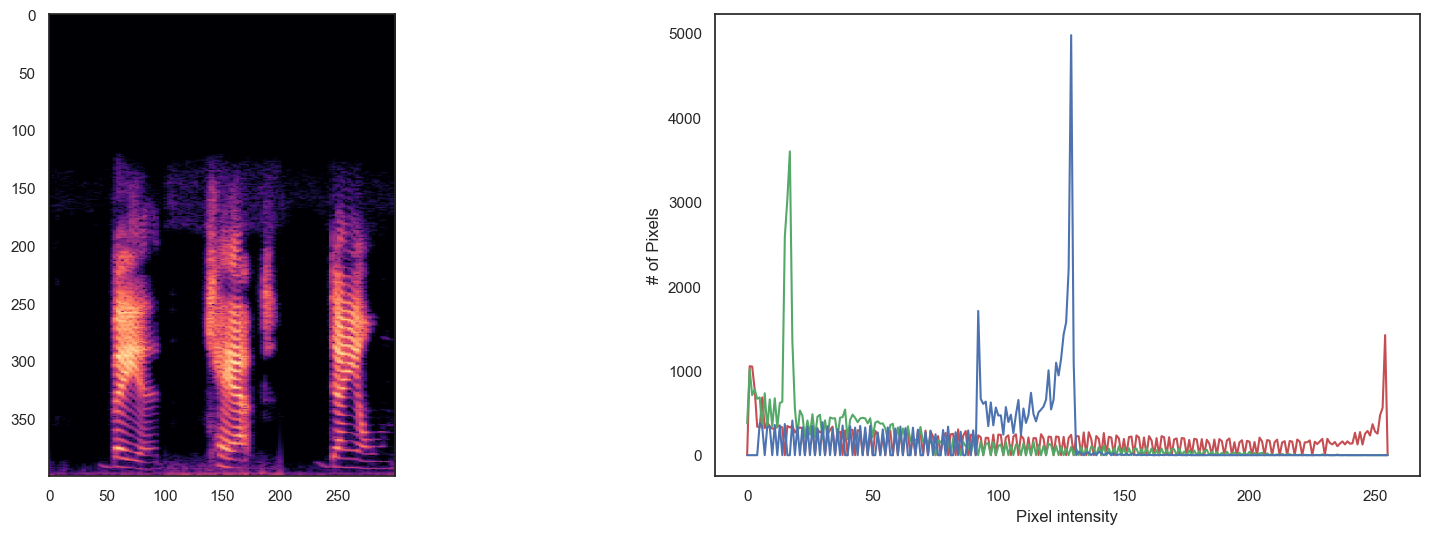

In [294]:
colorHistogram(speaker_1[0].file_path, black_threshold=5)

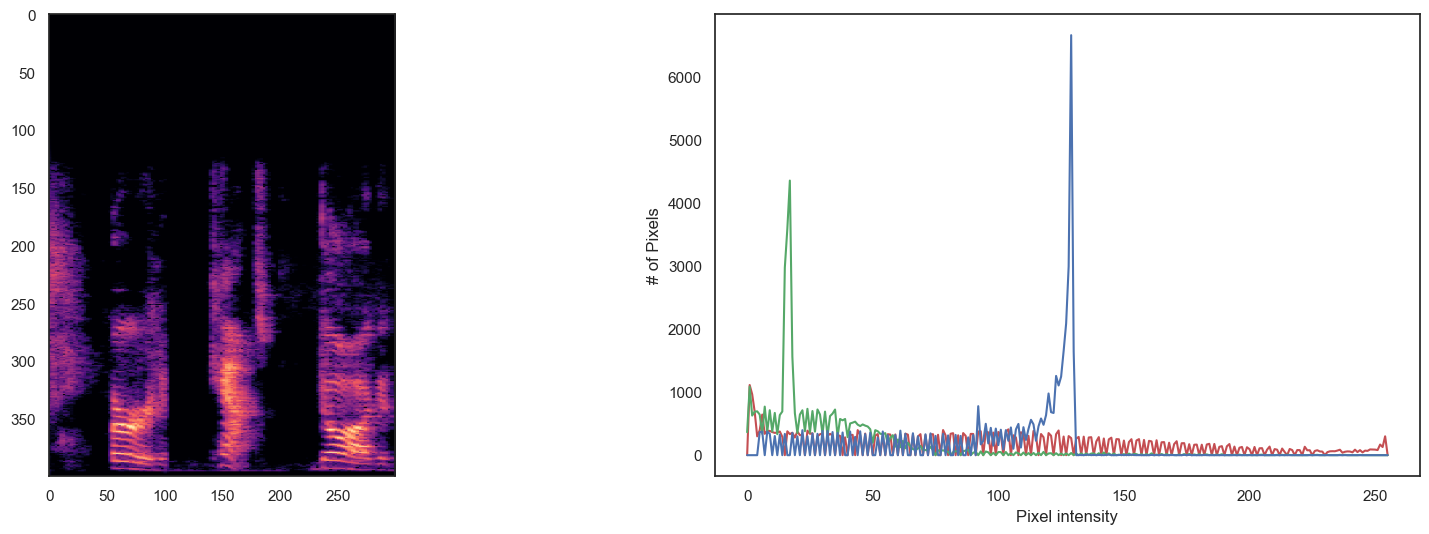

In [295]:
colorHistogram(speaker_2[0].file_path, black_threshold=5)